## Imports and data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
import cv2
import numpy as np
import PIL.Image as Image
import copy
from PIL import ImageFilter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_folder_regex = '/content/drive/MyDrive/SRCNN DATA/Train/*'
images = glob.glob(train_folder_regex)
train_data = []
labels_data = []
scale = 3
for image in images:
    hr = Image.open(image).convert('RGB')
    hr_width = (hr.width // scale) * scale
    hr_height = (hr.height // scale) * scale
    hr = hr.resize((hr_width, hr_height), resample=Image.BICUBIC)
    lr = hr.filter(ImageFilter.GaussianBlur(radius=3))
    lr = lr.resize((hr_width // scale, hr_height // scale), resample=Image.BICUBIC)
    lr = lr.resize((lr.width * scale, lr.height * scale), resample=Image.BICUBIC)
    hr = np.moveaxis(np.array(hr).astype(np.float32), 2, 0)
    lr = np.moveaxis(np.array(lr).astype(np.float32), 2, 0)
    train_data.append(lr)
    labels_data.append(hr)

## Network architecture

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, (5,5), padding=2)
        self.conv2 = nn.Conv2d(128, 64, (5,5), padding=2)
        self.conv3 = nn.Conv2d(64, 3, (5,5), padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

## Training

In [5]:
num_epochs = 20
lr = 1e-4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam([
        {'params': model.conv1.parameters()},
        {'params': model.conv2.parameters()},
        {'params': model.conv3.parameters(), 'lr': lr * 0.1}
    ], lr=lr)
best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0
best_psnr = 0.0

total_loss_list = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i in range(len(train_data)):
        inputs = train_data[i][None,:,:,:]
        labels = labels_data[i][None,:,:,:]
        inputs = torch.from_numpy(inputs).to(device)
        labels = torch.from_numpy(labels).to(device)
        preds = model(inputs)
        loss = criterion(preds, labels)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(epoch, total_loss)
    total_loss_list.append(total_loss)

0 352497.2257385254
1 58582.888122558594
2 43117.387351989746
3 36246.786602020264
4 33684.972789764404
5 32309.813020706177
6 31916.38204574585
7 31408.41157913208
8 31053.78017425537
9 30176.743770599365
10 29822.114292144775
11 29232.907833099365
12 29824.759437561035
13 29084.578369140625
14 29738.47671508789
15 28364.285900115967
16 28155.780696868896
17 28162.583137512207
18 29751.794525146484
19 28602.256099700928


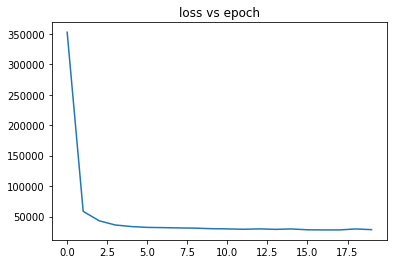

In [6]:
import matplotlib.pyplot as plt
plt.plot(total_loss_list)
plt.title('loss vs epoch')
plt.show()

## Testing

In [7]:
train_folder_regex = '/content/drive/MyDrive/SRCNN DATA/Test/Set5/*'
images = glob.glob(train_folder_regex)
train_data = []
labels_data = []
scale = 3
for image in images:
    hr = Image.open(image).convert('RGB')
    hr_width = (hr.width // scale) * scale
    hr_height = (hr.height // scale) * scale
    hr = hr.resize((hr_width, hr_height), resample=Image.BICUBIC)
    lr = hr.filter(ImageFilter.GaussianBlur(radius=3))
    lr = lr.resize((hr_width // scale, hr_height // scale), resample=Image.BICUBIC)
    lr = lr.resize((lr.width * scale, lr.height * scale), resample=Image.BICUBIC)
    hr = np.moveaxis(np.array(hr).astype(np.float32), 2, 0)
    lr = np.moveaxis(np.array(lr).astype(np.float32), 2, 0)
    train_data.append(lr)
    labels_data.append(hr)

In [8]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

psnr = 29.188058160247632


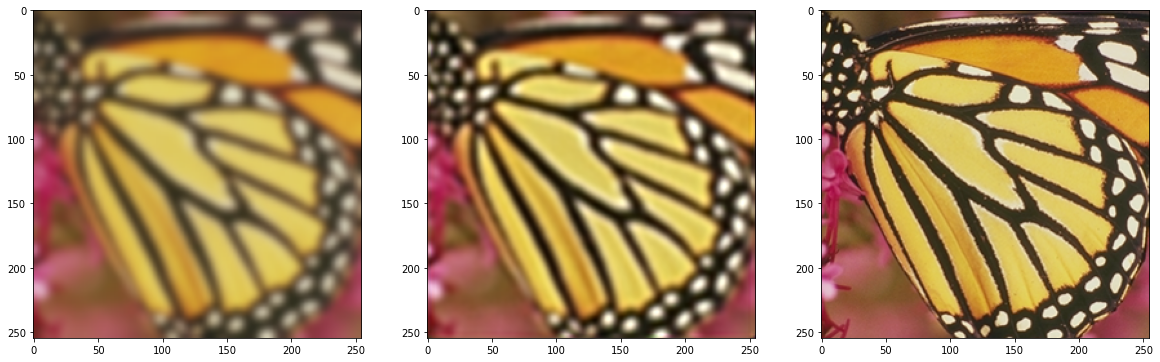

psnr = 31.93261788085254


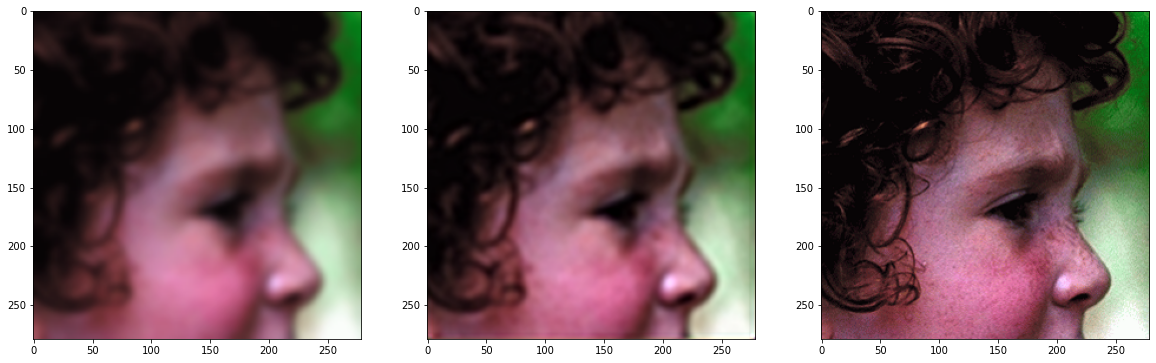

psnr = 31.435291159213236


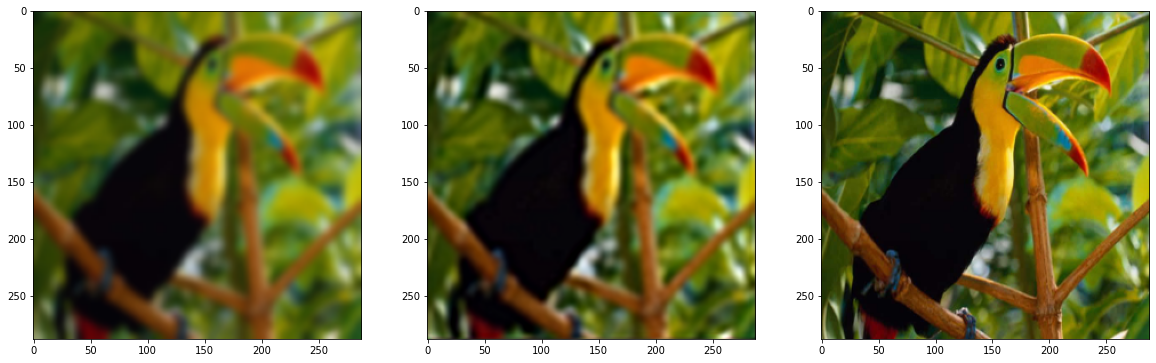

psnr = 31.245921950050786


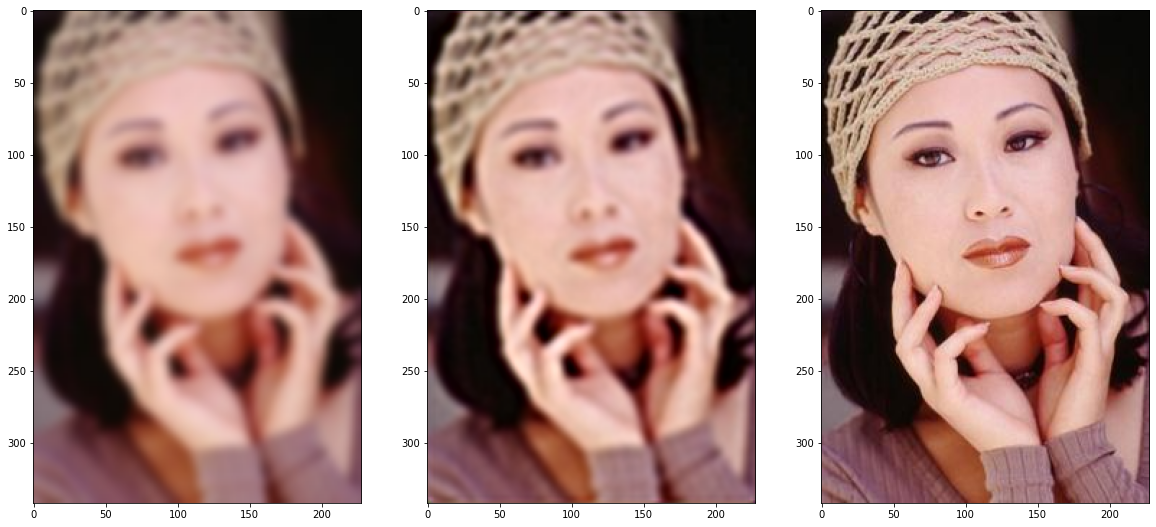

psnr = 32.47319787839758


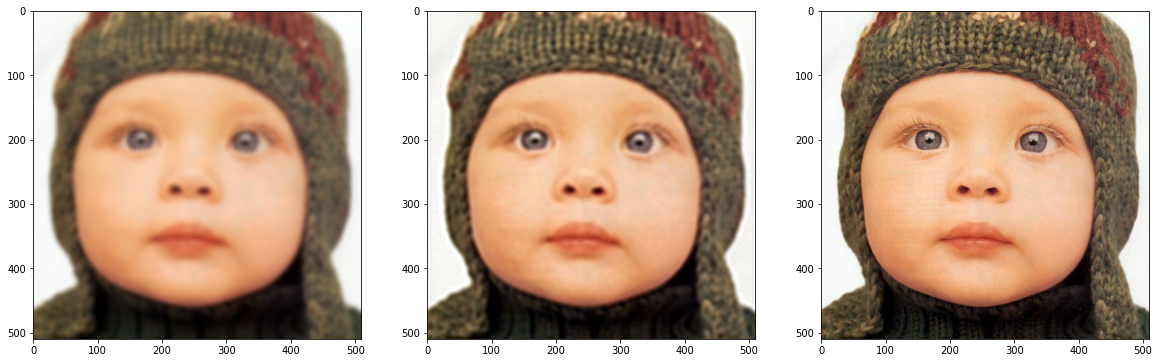

In [9]:
for i in range(len(train_data)):
    plt.figure(figsize=(20,20))
    sample = train_data[i]
    real = labels_data[i]

    plt.subplot(131)
    plt.imshow(np.moveaxis(sample.astype(np.uint8), 0, 2))
    
    plt.subplot(132)
    super_res = model(torch.from_numpy(sample[None,:,:,:]).to(device)).cpu().detach().numpy()
    super_res = np.moveaxis(np.clip(super_res, 0, 255).astype(np.uint8)[0],0,2)
    plt.imshow(super_res)

    plt.subplot(133)
    plt.imshow(np.moveaxis(real.astype(np.uint8), 0, 2))
    
    print('psnr =', PSNR(np.moveaxis(real.astype(np.uint8), 0, 2), super_res))

    plt.show()

(3, 342, 228) <class 'numpy.ndarray'> float32
(3, 342, 228) <class 'numpy.ndarray'> float32
psnr = 29.487281690467295


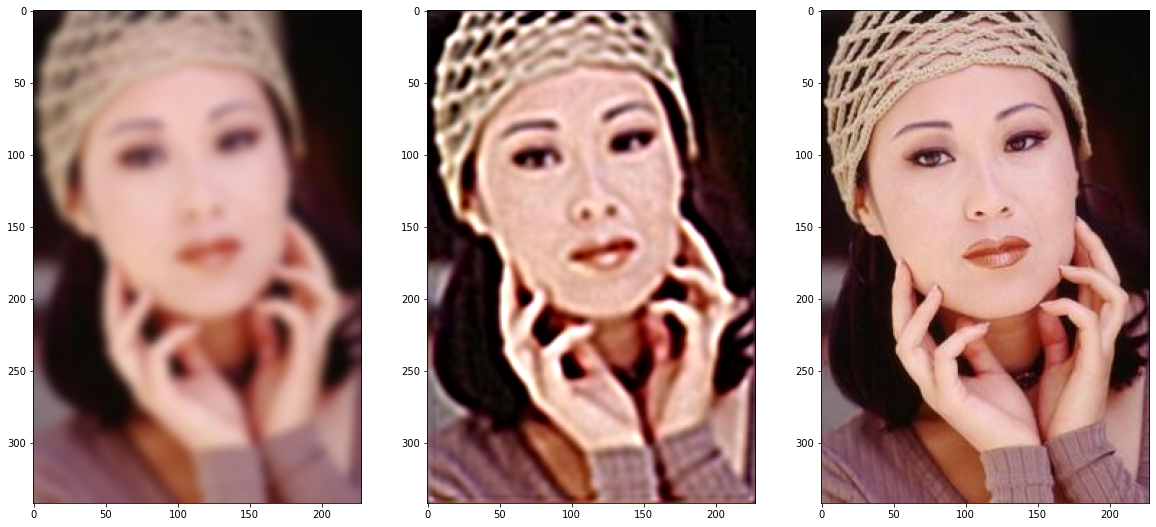

In [10]:
for i in [3]:
    plt.figure(figsize=(20,20))
    sample = train_data[i]
    real = labels_data[i]

    plt.subplot(131)
    plt.imshow(np.moveaxis(sample.astype(np.uint8), 0, 2))
    
    plt.subplot(132)
    print(sample.shape, type(sample), sample.dtype)
    super_res = model(torch.from_numpy(sample[None,:,:,:]).to(device)).cpu().detach().numpy()
    super_res = np.clip(super_res, 0, 255).astype(np.float32)[0]

    print(super_res.shape, type(super_res), super_res.dtype)
    super_res = model(torch.from_numpy(super_res[None,:,:,:]).to(device)).cpu().detach().numpy()
    super_res = np.moveaxis(np.clip(super_res, 0, 255).astype(np.uint8)[0],0,2)

    plt.imshow(super_res)

    plt.subplot(133)
    plt.imshow(np.moveaxis(real.astype(np.uint8), 0, 2))
    
    print('psnr =', PSNR(np.moveaxis(real.astype(np.uint8), 0, 2), super_res))

    plt.show()